In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from sklearn.metrics import classification_report
import time 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os

directory = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train'
contents = os.listdir(directory)
num_of_dirs = len([name for name in contents if os.path.isdir(os.path.join(directory, name))])

print("Contents of the directory:")
for item in contents:
    print(item)

print(f"\nNumber of directories: {num_of_dirs}")


Contents of the directory:
labels
images

Number of directories: 2


In [3]:
from PIL import Image
import os

# Define the directory path
directory_path = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train'

# List all files in the directory
file_names = os.listdir(directory_path)

# Load images from the directory
images = []
for file_name in file_names:
    if file_name.endswith('.png') or file_name.endswith('.jpg') or file_name.endswith('.jpeg'):
        image_path = os.path.join(directory_path, file_name)
        image = Image.open(image_path)
        images.append(image)

# Process the images as required
# ...

# Example: Showing the first image
if images:
    images[0].show()
else:
    print("No images found in the directory.")

No images found in the directory.


In [4]:
# Define parameters
batch_size = 128
num_epochs = 10
image_size = (139, 139)
num_classes = 2


In [5]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [6]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
class_outputs = Dense(num_classes, activation='softmax')(x)


In [7]:

# Create the model
model = Model(inputs=base_model.input, outputs=class_outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Load the training data with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the validation data with moderate data augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_dataset = val_datagen.flow_from_directory(
    '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/valid',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif 10 <= epoch < 20:
        return 0.0001
    else:
        return 0.00001

lr_schedule = LearningRateScheduler(lr_scheduler)

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[lr_schedule, early_stop, checkpoint, reduce_lr]
)



Found 2469 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.5520
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 61s 2s/step - loss: 0.9854 - accuracy: 0.5520 - val_loss: 0.1529 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.6962
Epoch 2: val_accuracy did not improve from 1.00000
20/20 [==============================] - 29s 1s/step - loss: 0.6183 - accuracy: 0.6962 - val_loss: 0.4921 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8408
Epoch 3: val_accuracy did not improve from 1.00000
20/20 [==============================] - 29s 1s/step - loss: 0.4151 - accuracy: 0.8408 - val_loss: 0.2174 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9259
Epoch 4: val_accuracy did not improve from 1.00000
20/20 [==============================] - 29s 1s/step - loss: 0.2695 - accuracy: 0.9259 - val_loss: 0.1896 - val_accuracy: 0.9915 - lr: 0.00

In [8]:
# Save the model in native Keras format
# model.save("/kaggle/working/")

# import joblib

# # Save the model using joblib
# joblib.dump(model, 'plant_disease_model_inception.pkl')


In [9]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
img_path = '/kaggle/input/image-only/agri_0_9527.jpeg'
img = image.load_img(img_path, target_size=(139, 139))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 2s 2s/step
[[0.02165188 0.9783481 ]]


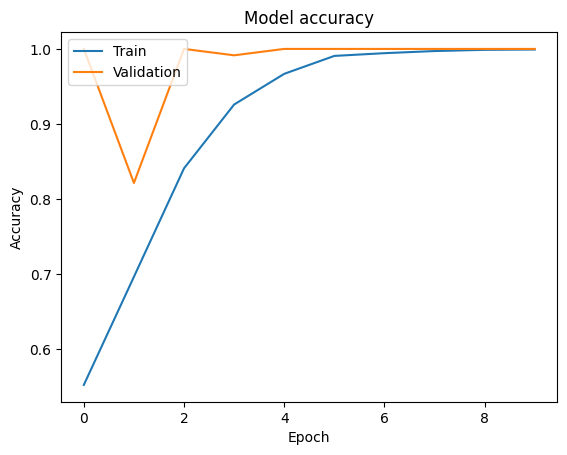

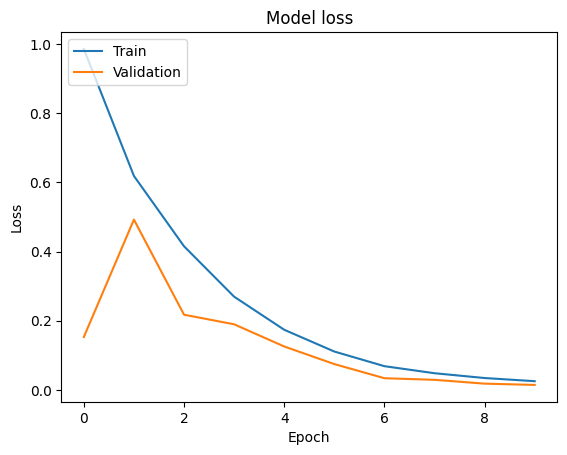

In [10]:
# Plot the metrics to visualize the training process
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_metrics(history)

In [11]:
# # Evaluate the model on the test data
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_dataset = test_datagen.flow_from_directory(
#     '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test',
#     target_size=(139, 139),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_labels = test_dataset.classes
# test_labels = to_categorical(test_labels, num_classes=num_classes)

# start_time = time.time()
# y_pred = model.predict(test_dataset)
# y_pred_bool = np.argmax(y_pred, axis=1)
# rounded_labels = np.argmax(test_labels, axis=1)

# print(classification_report(y_pred_bool, rounded_labels, digits=4))
# print("Time taken to predict the model: " + str(time.time() - start_time))

# # Save the model
# model.save('plant_disease_model_inception.h5')


In [12]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing import image
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt 

# # Load your trained model
# model = tf.keras.models.load_model('/kaggle/working/plant_disease_model_inception.h5')  # Replace 'your_model_directory' with the path to your saved model

# # Load and preprocess your image
# img_path = '/kaggle/input/weed-detection/test/ridderzuring_3126_jpg.rf.8980b3ae3ec4ecd023aab5bc54c26089.jpg'  # Replace 'path_to_your_image.jpg' with your image file path
# img = image.load_img(img_path, target_size=(139, 139))  # Resize to match the input size of your model


In [13]:
# # Load and preprocess your image
# img_path = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg'  # Replace with the path to your image file
# img = tf.keras.preprocessing.image.load_img(img_path, target_size=(139, 139))  # Load the image and resize
# img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
# img_array = tf.image.resize(img_array, (139, 139))  # Resize the image to match the model's input size
# img_array = tf.expand_dims(img_array, axis=0)  # Add a batch dimension

# # Get the predictions for the image
# predictions = model.predict(img_array)
# predicted_class = tf.argmax(predictions[0])

In [14]:
# # Get the predictions for the image
# predictions = model.predict(img_array)
# predicted_class = np.argmax(predictions[0])

# # Generate the heatmap
# last_conv_layer = model.get_layer('mixed10')  
# heatmap_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

# with tf.GradientTape() as tape:
#     conv_outputs, predictions = heatmap_model(img_array)
#     loss = predictions[:, predicted_class]

# grads = tape.gradient(loss, conv_outputs)
# pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
# heatmap = np.maximum(heatmap, 0)

# heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# # Convert both arrays to the same data type (e.g., unsigned 8-bit integer)
# img_array_uint8 = (img_array[0].numpy() * 255).astype(np.uint8)
# heatmap_resized_uint8 = (heatmap_resized * 255).astype(np.uint8)  # Adjust the range of heatmap values

# # Overlay the heatmap on the original image
# heatmap_resized_uint8 = cv2.applyColorMap(heatmap_resized_uint8, cv2.COLORMAP_JET)
# superimposed_img = cv2.addWeighted(img_array_uint8, 0.6, heatmap_resized_uint8, 0.4, 0)



In [15]:
# # Display the original image, heatmap, and overlay
# plt.figure(figsize=(12, 6))

# plt.subplot(131)
# plt.imshow(img)
# plt.title('Original Image')

# plt.subplot(132)
# plt.imshow(heatmap_resized_uint8)
# plt.title('Heatmap')

# plt.subplot(133)
# plt.imshow(superimposed_img)
# plt.title('Overlay')

# plt.tight_layout()
# plt.show()